In [12]:
# Standard imports
import os
import time
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

In [13]:
# Set random seed and device
torch.manual_seed(1)
device = torch.device("cuda")
print('Device:', device)

Device: cuda


In [14]:
# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [15]:
# Create directories
os.makedirs('Results', exist_ok=True)
os.makedirs('Models', exist_ok=True)

In [16]:
# Dataset setup
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.CIFAR10(
    root="./dataset/CIFAR10data",
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

Files already downloaded and verified


In [17]:
# Display training images
def display_training_images(dataloader, device):
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),
        (1,2,0)
    ))

In [18]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

def initialize_weights(model):
    """Initialize model weights to normal distribution with mean=0, std=0.02"""
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def clip_weights(critic):
    for p in critic.parameters():
        p.data.clamp_(-0.01, 0.01)

def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Compute gradient penalty for WGAN-GP"""
    batch_size, C, H, W = real_samples.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).to(device)
    alpha = alpha.expand(batch_size, C, H, W)
    
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    critic_interpolated = critic(interpolated)
    
    gradients = torch.autograd.grad(
        outputs=critic_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_interpolated),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [19]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network for FID calculation"""
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {64: 0, 192: 1, 768: 2, 2048: 3}

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, 
                 normalize_input=True, requires_grad=False):
        super(InceptionV3, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Block definitions...
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)
            if idx == self.last_needed_block:
                break

        return outp

In [20]:
def calculate_fid(real_images, fake_images, model):
    """Calculate FID score between real and fake images"""
    mu_real, std_real = calculate_activation_statistics(real_images, model, cuda=True)
    mu_fake, std_fake = calculate_activation_statistics(fake_images, model, cuda=True)
    fid_value = calculate_frechet_distance(mu_real, std_real, mu_fake, std_fake)
    return fid_value

def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=True):
    model.eval()
    act = np.empty((len(images), dims))
    
    batch = images.cuda() if cuda else images
    pred = model(batch)[0]
    
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))
        
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate Frechet distance between two multivariate Gaussians"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape
    assert sigma1.shape == sigma2.shape

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [ ]:
# Initialize models
generator = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

# Optimizers
gen_optimizer = optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

# Fixed noise for visualization
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

# Initialize FID model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).to(device)

generator.train()
discriminator.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [ ]:
# Training initialization
generator_losses = []
discriminator_losses = []
generated_images = []
fid_scores = []
wasserstein_distances = []
iterations = 0

print("Starting Training...")
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Train Critic (Discriminator)
        discriminator.train()
        generator.eval()
        for _ in range(CRITIC_ITERATIONS):
            disc_optimizer.zero_grad()
            
            # Generate fake images
            noise = torch.randn(current_batch_size, NOISE_DIM, 1, 1).to(device)
            with torch.no_grad():
                fake_images = generator(noise)
            
            # Compute critic losses
            critic_real = discriminator(real_images).reshape(-1)
            critic_fake = discriminator(fake_images.detach()).reshape(-1)
            
            # Calculate Wasserstein distance and track it
            wasserstein_distance = torch.mean(critic_real) - torch.mean(critic_fake)
            wasserstein_distances.append(wasserstein_distance.item())
            
            # Gradient penalty
            gp = compute_gradient_penalty(discriminator, real_images, fake_images)
            
            # Wasserstein loss with gradient penalty
            critic_loss = -wasserstein_distance + LAMBDA_GP * gp
            
            critic_loss.backward(retain_graph=True)
            disc_optimizer.step()

        # Train Generator (only every n_critic iterations)
        if batch_idx % CRITIC_ITERATIONS == 0:
            generator.train()
            discriminator.eval()
            
            gen_optimizer.zero_grad()
            noise = torch.randn(current_batch_size, NOISE_DIM, 1, 1).to(device)
            fake_images = generator(noise)
            gen_fake = discriminator(fake_images).reshape(-1)
            gen_loss = -torch.mean(gen_fake)
            
            gen_loss.backward()
            gen_optimizer.step()

            # Record losses
            generator_losses.append(gen_loss.item())
            discriminator_losses.append(critic_loss.item())

        # Save generated images periodically
        if (iterations % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            generated_images.append(vutils.make_grid(fake, padding=2, normalize=True))

        iterations += 1

    # Calculate FID score for epoch
    with torch.no_grad():
        fid_score = calculate_fid(real_images, fake_images, inception_model)
        fid_scores.append(fid_score)

    # Progress reporting
    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} '
              f'Loss D: {critic_loss:.3f}, Loss G: {gen_loss:.3f} FID: {fid_score:.3f} '
              f'W-Distance: {wasserstein_distance:.3f}')

    # Save generated and real images
    os.makedirs('Results/WGAN_FAKE', exist_ok=True)
    os.makedirs('Results/WGAN_REAL', exist_ok=True)

    with torch.no_grad():
        fake_samples = generator(fixed_noise)
        vutils.save_image(fake_samples.detach(),
                         f'Results/WGAN_FAKE/WGAN_epoch_{epoch:03d}.png',
                         normalize=True)
        vutils.save_image(real_images.detach(),
                         f'Results/WGAN_REAL/WGAN_epoch_{epoch:03d}.png',
                         normalize=True)

training_time = time.time() - training_start_time
print(f'\nTraining completed in {training_time:.2f} seconds')

Starting Training...
Epoch [1/40] Batch 390/391 Loss D: -88.837, Loss G: 144.815 FID: 319.469 W-Distance: 133.622
Epoch [6/40] Batch 390/391 Loss D: -45.965, Loss G: 179.283 FID: 258.190 W-Distance: 62.680
Epoch [11/40] Batch 390/391 Loss D: -30.102, Loss G: 142.981 FID: 231.566 W-Distance: 41.484
Epoch [16/40] Batch 390/391 Loss D: -18.387, Loss G: 126.897 FID: 215.757 W-Distance: 24.275
Epoch [21/40] Batch 390/391 Loss D: -22.122, Loss G: 122.607 FID: 230.304 W-Distance: 26.452
Epoch [26/40] Batch 390/391 Loss D: -19.247, Loss G: 135.373 FID: 230.091 W-Distance: 27.297
Epoch [31/40] Batch 390/391 Loss D: -19.869, Loss G: 132.674 FID: 244.534 W-Distance: 27.380
Epoch [36/40] Batch 390/391 Loss D: -22.535, Loss G: 144.219 FID: 235.476 W-Distance: 29.915

Training completed in 7286.76 seconds


In [25]:
def save_training_results(gen_losses, disc_losses, fid_scores, img_list, wasserstein_distances):
    """Save and plot training results"""
    # Create directories
    os.makedirs('Results/Loss_Data', exist_ok=True)
    os.makedirs('Results/FID_score', exist_ok=True)
    
    # Save losses and FID scores
    np.save('Results/Loss_Data/WGAN_GLoss', gen_losses)
    np.save('Results/Loss_Data/WGAN_DLoss', disc_losses)
    np.save('Results/FID_score/WGAN_FID', fid_scores)
    
    # Plot and save loss curves
    plt.figure(figsize=(10,5))
    plt.title("Generator and Critic Loss During Training")
    plt.plot(gen_losses, label="Generator")
    plt.plot(disc_losses, label="Critic")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('Results/wgan_loss.png', format='png', bbox_inches='tight')
    plt.close()
    
    # Plot and save FID scores
    plt.figure(figsize=(10,5))
    plt.title("FID Scores for WGAN-GP")
    plt.plot(fid_scores, label="WGAN-GP")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.legend()
    plt.savefig('Results/wgan_FID.png', format='png', bbox_inches='tight')
    plt.close()

    # Wasserstein distance plot
    plt.figure(figsize=(10,5))
    plt.title("Wasserstein Distance During Training")
    plt.plot(wasserstein_distances, label="Wasserstein Distance")
    plt.xlabel("Iterations")
    plt.ylabel("Distance")
    plt.legend()
    plt.savefig('Results/wasserstein_distance.png', format='png', bbox_inches='tight')
    plt.close()
    
    # Plot real vs fake images
    plot_real_vs_fake_images(dataloader, img_list[-1], device)

def plot_real_vs_fake_images(dataloader, final_fake_images, device):
    """Plot and save real vs generated images"""
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(15,15))
    
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(
        real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
    
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(final_fake_images,(1,2,0)))
    
    plt.savefig('Results/WGAN_BEST_FAKE_32.png', format='png', bbox_inches='tight')
    plt.close()


Final Statistics:
Generator Loss - Mean: 139.9460, Min: 2.3845, Final: 157.4218
Critic Loss - Mean: -27.7095, Min: -110.6858, Final: -19.4890
FID Scores - Min: 211.3203, Max: 319.4690, Mean: 240.4120, Final: 255.2490


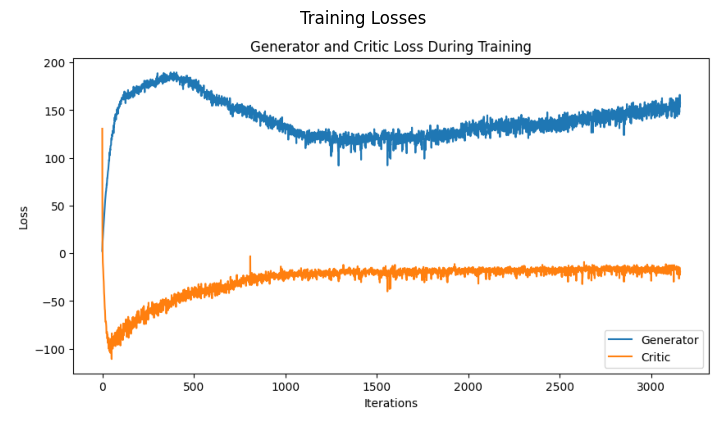

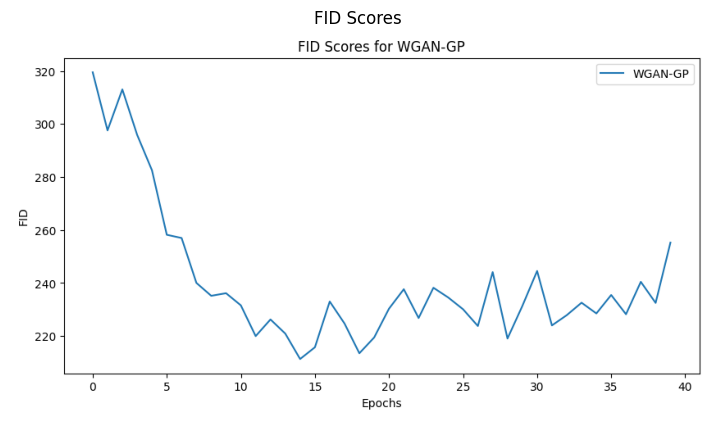

In [26]:
# Save and plot final results
save_training_results(generator_losses, discriminator_losses, fid_scores, generated_images, wasserstein_distances)

# Print final statistics
print("\nFinal Statistics:")
print(f"Generator Loss - Mean: {np.mean(generator_losses):.4f}, Min: {np.min(generator_losses):.4f}, Final: {generator_losses[-1]:.4f}")
print(f"Critic Loss - Mean: {np.mean(discriminator_losses):.4f}, Min: {np.min(discriminator_losses):.4f}, Final: {discriminator_losses[-1]:.4f}")
print(f"FID Scores - Min: {np.min(fid_scores):.4f}, Max: {np.max(fid_scores):.4f}, Mean: {np.mean(fid_scores):.4f}, Final: {fid_scores[-1]:.4f}")

# Display final plots
plt.figure(figsize=(10,5))
img = plt.imread('Results/wgan_loss.png')
plt.imshow(img)
plt.axis('off')
plt.title("Training Losses")
plt.show()

plt.figure(figsize=(10,5))
img = plt.imread('Results/wgan_FID.png')
plt.imshow(img)
plt.axis('off')
plt.title("FID Scores")
plt.show()

In [27]:
# Save models
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'gen_optimizer_state_dict': gen_optimizer.state_dict(),
    'disc_optimizer_state_dict': disc_optimizer.state_dict(),
}, 'Models/wgan_checkpoint.pth')